# Analyzing the Impact of Scheduling Strategy on Blocking Probability

* In this notebook, we simulate the impact of scheduling strategy on `blocking probability` 
* Base Station (BS) scheduler allocates different set of CCEs to different UEs based on a certain `strategy`
* For instance, let us consider two scheduling strategies namely `strategy 1` and `strategy 2`, where
    * `strategy 1`: scheduler allocates UEs from low-to-high ALs. i.e., UEs with lower AL are scheduled first.
    * `strategy 2`: scheduler allocates UEs from high-to-low ALs. i.e., UEs with higher AL are scheduled first.



## Python Libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# %matplotlib widget
import matplotlib.pyplot  as plt
import matplotlib.patches as mpatches
import matplotlib as mpl

import numpy      as np

## 5G-Toolkit Libraries

In [2]:
import sys
sys.path.append("../../")
from toolkit5G.Scheduler import PDCCHScheduler

## Simulation Parameters
The following parameters are used for this simulation:
- `coresetID` denotes the coreset ID.
- `slotNumber` denotes the slot-number carrying the PDCCH.
- `searchSpaceType` denotes the search space type. UE specific search space (USS) or Common search space (CSS).
- `nci` denotes the variable corresponding to carrier aggregation. Current simulation does not assume carrier aggregation.

In [3]:

mu                = np.random.randint(4)    # numerlogy for sub-carrier spacing
coresetID         = 1                       # coreset ID
slotNumber        = 0               
searchSpaceType   = "USS"                   # search space type. UE specific search space
nci               = 0                       # variable corresponding to carrier aggregation 
numIterations     = 1000


## PDCCH Scheduling Parameters
Following parameters are crucial for PDCCH scheduling performance:
- ``Nccep`` denotes coreset size or number of CCEs available for scheduling UEs.
- ``strategy`` denotes the scheduling strategy.
- ``numCandidatesUnderEachAL`` denotes number of PDCCH candidates per aggregation level.
- ``aggLevelProbDistribution`` denotes the probability distribution with which the scheduler chooses a particular aggregation level (AL) for each UE. Supported ALs under USS are 1,2,4,8,16.  

In [4]:
Nccep                    = 54
maxNumUEs                = 40
numUEs                   = np.arange(5,maxNumUEs+1,5)
aggLevelProbDistribution = np.array([0.4, 0.3, 0.2, 0.05, 0.05])
numCandidates            = np.array([6,6,4,2,1], dtype=int)
pdcchSchedulerObj        = PDCCHScheduler(mu, slotNumber, coresetID, nci)


## Simulation for Scheduling Strategy-I

In [5]:
##############
# Strategy 1
##############
strategy                   = "Conservative" 
probOfBlockingForStrategy1 = np.zeros((numUEs.shape))

for n in range(numUEs.size):    
    print("Simulating (n,numUEs) : "+str(n)+", "+str(numUEs[n])) 
    prob      = 0
    for i in range(numIterations):   
        ueALdistribution  = np.random.multinomial(numUEs[n], aggLevelProbDistribution)
        rnti              = np.random.choice( np.arange(1,65519+1), size = (numUEs[n],), replace=False)
        count             = pdcchSchedulerObj(Nccep,searchSpaceType,ueALdistribution,numCandidates,rnti,strategy)[0]
        numBlockedUEs     = np.sum(count)
        prob              = prob + numBlockedUEs/numUEs[n]
    probOfBlockingForStrategy1[n] = prob/numIterations
    

Simulating (n,numUEs) : 0, 5
Simulating (n,numUEs) : 1, 10
Simulating (n,numUEs) : 2, 15
Simulating (n,numUEs) : 3, 20
Simulating (n,numUEs) : 4, 25
Simulating (n,numUEs) : 5, 30
Simulating (n,numUEs) : 6, 35
Simulating (n,numUEs) : 7, 40


### Blocking probability vs number of UEs to be scheduled.

* Its the recreation of ``Fig. 4: Blocking probability versus number of UEs to be scheduled.`` from the reference     paper referenced below [1].
* Figure shows that by doubling the number of UEs from 15 to 30, the blocking probability increases from 0.15 to 0.3, corresponding to an increase by a factor of 2.


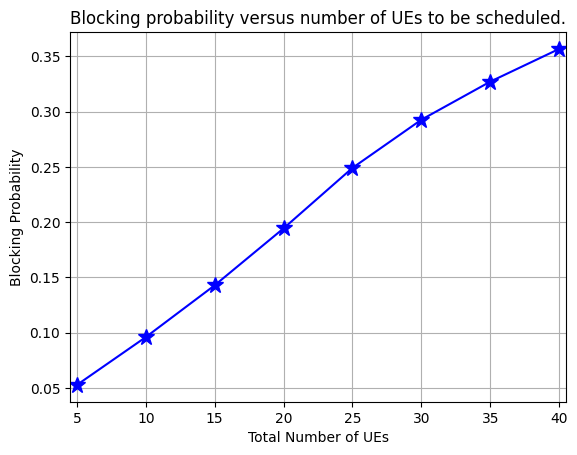

In [6]:
fig, ax = plt.subplots()
ax.plot(numUEs, probOfBlockingForStrategy1, marker  = "*",linestyle = "solid", ms = 12, c = 'b')

ax.set_xlabel('Total Number of UEs')
ax.set_ylabel('Blocking Probability')
ax.set_title('Blocking probability versus number of UEs to be scheduled.', fontsize=12) 
ax.set_xticks(numUEs)
ax.set_xlim([numUEs[0]-0.5, numUEs[-1]+0.5])
ax.grid()
plt.show()

## Simulation for Scheduling Strategy-II

In [7]:
##############
# Strategy 2
##############
strategy = "Aggressive" 
probOfBlockingForStrategy2 = np.zeros((numUEs.shape))

for n in range(numUEs.size):    
    print("Simulating (n,numUEs) : "+str(n)+", "+str(numUEs[n])) 
    prob      = 0
    for i in range(numIterations):
        ueALdistribution  = np.random.multinomial(numUEs[n], aggLevelProbDistribution)
        rnti              = np.random.choice( np.arange(1,65519+1), size = (numUEs[n],), replace=False)
        count             = pdcchSchedulerObj(Nccep,searchSpaceType,ueALdistribution,numCandidates,rnti,strategy)[0]
        numBlockedUEs     = np.sum(count)
        prob              = prob + numBlockedUEs/numUEs[n]
    probOfBlockingForStrategy2[n] = prob/numIterations

Simulating (n,numUEs) : 0, 5
Simulating (n,numUEs) : 1, 10
Simulating (n,numUEs) : 2, 15
Simulating (n,numUEs) : 3, 20
Simulating (n,numUEs) : 4, 25
Simulating (n,numUEs) : 5, 30
Simulating (n,numUEs) : 6, 35
Simulating (n,numUEs) : 7, 40


## Plotting Blocking Probability vs Number of UEs for Scheduling Strategy

* Its the recreation of ``Fig. 10: Blocking probability for different scheduling strategies``from the paper referenced below [1]. 

* Figure shows that ``strategy 1 outperforms strategy 2 in terms of blocking probability``.

* The reason is that strategy 2 prioritizes UEs with high ALs that uses more number of CCEs, thus resulting in a higher blocking probability compared to strategy 1.
* For instance, in strategy 2, a UE using AL 16 may block 16 UEs using AL 1.


* Also from the figure, we see that for a small number of UEs (e.g., 15) the two scheduling strategies have the same performance. However, when number of UEs increases to 40, blocking probability under strategy 2 is aproximately 3.5 times larger than the case with strategy 1, in the CORESET size of 54 CCEs.


* Note that the performance of different scheduling strategies is also ``dependent on the CORESET size``.

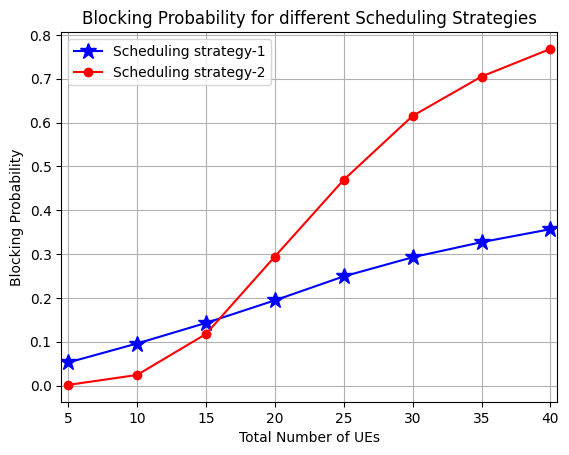

In [8]:
fig, ax = plt.subplots()
ax.plot(numUEs, probOfBlockingForStrategy1, marker  = "*",linestyle = "solid", ms = 12, c = 'b', label = "Scheduling strategy-1")
ax.plot(numUEs, probOfBlockingForStrategy2, marker  = "o",linestyle = "solid", ms = 6,  c = 'r', label = "Scheduling strategy-2")

ax.legend()
ax.set_xlabel('Total Number of UEs')
ax.set_ylabel('Blocking Probability')
ax.set_title('Blocking Probability for different Scheduling Strategies', fontsize=12) 
ax.set_xticks(numUEs)
ax.set_xlim([numUEs[0]-0.5, numUEs[-1]+0.5])
ax.grid()
plt.show()

### References

[1] `Blocking Probability Analysis for 5G New Radio (NR) Physical Downlink Control Channel`. Mohammad Mozaffari,
      Y.-P. Eric Wang, and Kittipong Kittichokechai